In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
#TODO: Nesterov, Newton (logistic regression), ADAMAX, 

In [86]:
#compute the equation y=a*x+b
def f(x,a,b):
    return a*x[:,0]+b

#return the mse
def get_error(x,a,b):
    return 0.5*np.mean((f(x,a,b)-x[:,1])**2)

#return partial derivative according to a and b
def get_gradient(x,a,b):
    return np.mean(x[:,0]*(f(x,a,b)-x[:,1]),axis=-1),np.mean(f(x,a,b)-x[:,1],axis=-1)

def get_gradient_with_l2_norm(x,a,b,norm_coef):
    return np.mean(x[:,0]*(f(x,a,b)-x[:,1]),axis=-1)+norm_coef*0.5*(a)**(-0.5),np.mean(f(x,a,b)-x[:,1],axis=-1)+norm_coef*0.5*(b)**(-0.5)

def get_gradient_with_l1_norm(x,a,b,norm_coef):
    return np.mean(x[:,0]*(f(x,a,b)-x[:,1]),axis=-1)+norm_coef*abs(a),np.mean(f(x,a,b)-x[:,1],axis=-1)+norm_coef*abs(b)


#generate a set of data points
#first column is abscisse
#second column is ordinate
def generate_data(point_nb):
    x=np.array(())
    for i in range(point_nb):
        x=np.insert(x,len(x),i)
        x=np.insert(x,len(x),i+np.random.rand()*40)
    x=x.reshape((-1,2))
    return x

def plot_level_curve(xyz,x):
    xyz=xyz.reshape((-1,3))
    xx,yy=np.meshgrid(xyz[:400,0],xyz[:400,1],sparse=False,copy=False)
    z=np.array(())
    print 'waiting for z'
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            z=np.insert(z,len(z),get_error(x[:100],xx[i,j],yy[i,j]))
    CS = plt.contour(xx,yy,z.reshape(xx.shape))
    plt.clabel(CS, inline=1, fontsize=10)
    

In [150]:
def vanilla_gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=0.1):
    a=np.random.rand()
    b=np.random.rand()
    prev_error=0
    error_list=[]
    while True: 
        grada,gradb=get_gradient(x,a,b)
        if abs(get_error(x,a,b)-prev_error)<stop_error:
            break
        else:
            prev_error=get_error(x,a,b)
            error_list.append(prev_error)
            a-=(lamb*grada)
            b-=(lamb*gradb)
    error.plot(error_list,label='Vanilla')
    linear_reg.plot(x[:,0],f(x,a,b),label='Vanilla')
    return a,b,get_error(x,a,b)

In [145]:
#gradient descent with batch_size,momentum,decreasing learning rate
def gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=0.1,batch_size=50,momentum=0.09):
    a=np.random.rand()
    b=np.random.rand()
    a_prev=0
    b_prev=0
    prev_error=0
    error_list=[]
    while True:
        x=np.random.permutation(x)
        x_shuffled=x[:batch_size,:]        
        grada,gradb=get_gradient(x_shuffled,a,b)
        #print grada, gradb,a,b,error(x_shuffled,a,b)
        if abs(get_error(x_shuffled,a,b)-prev_error)<stop_error:
            break
        else:
            prev_error=get_error(x_shuffled,a,b)
            error_list.append(prev_error)
            a-=(lamb*grada+momentum*a_prev)
            b-=(lamb*gradb+momentum*b_prev)
            a_prev,b_prev=lamb*grada+momentum*a_prev,lamb*gradb+momentum*b_prev
            #lamb*=(1-1e-8)
    error.plot(error_list,label='batch_momentum')
    linear_reg.plot(x[:,0],f(x,a,b),label='batch_momentum')
    return a,b,get_error(x,a,b)

In [137]:
def gradient_descent_with_preprocessing(x,error,linear_reg,lamb=1e-5,stop_error=0.1,batch_size=50,momentum=0.09):
    x-=np.mean(x)
    x/=np.std(x)
    a=np.random.rand()
    b=np.random.rand()
    a_prev=0
    b_prev=0
    error_list=[]
    prev_error=0
    while True:
        x=np.random.permutation(x)
        x_shuffled=x[:batch_size,:]        
        grada,gradb=get_gradient(x_shuffled,a,b)
        #print grada, gradb,a,b,get_error(x_shuffled,a,b)
        if (abs(get_error(x_shuffled,a,b)-prev_error)<stop_error):
            break
        else:
            prev_error=get_error(x_shuffled,a,b)
            error_list.append(prev_error)
            a-=(lamb*grada+momentum*a_prev)
            b-=(lamb*gradb+momentum*b_prev)
            a_prev,b_prev=lamb*grada+momentum*a_prev,lamb*gradb+momentum*b_prev
            lamb*=(1-1e-8)
    error.plot(error_list,label='preprocessed')
    linear_reg.plot(x[:,0],f(x,a,b),label='preprocessed')
    return a,b,get_error(x,a,b)

In [161]:
def gradient_descent_with_l1_l2_norm(x,error,linear_reg,lamb=1e-5,stop_error=0.1,batch_size=50,momentum=0.09,norm='l2',norm_coef=1e-5):
    if norm=='l2':
        gradient_norm = lambda x,a,b,norm_coef: get_gradient_with_l2_norm(x,a,b,norm_coef)
    else:
        gradient_norm = lambda x,a,b,norm_coef: get_gradient_with_l1_norm(x,a,b,norm_coef)
        
    a=np.random.rand()
    b=np.random.rand()
    error_list=[]
    a_prev=0
    b_prev=0
    prev_error=0
    while True:
        x=np.random.permutation(x)
        x_shuffled=x[:batch_size,:]        
        grada,gradb=gradient_norm(x_shuffled,a,b,norm_coef)
        #print grada, gradb,a,b,get_error(x_shuffled,a,b)
        if (abs(get_error(x_shuffled,a,b)-prev_error)<stop_error):
            break
        else:
            prev_error=get_error(x_shuffled,a,b)
            error_list.append(prev_error)
            a-=(lamb*grada+momentum*a_prev)
            b-=(lamb*gradb+momentum*b_prev)
            a_prev,b_prev=lamb*grada+momentum*a_prev,lamb*gradb+momentum*b_prev
            lamb*=(1-1e-8)
    error.plot(error_list,label=norm+'_'+str(norm_coef))
    linear_reg.plot(x[:,0],f(x,a,b),label=norm+'_'+str(norm_coef))
    return a,b,get_error(x,a,b)

In [132]:
def adagrad_gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=0.1):
    a=np.random.rand()
    b=np.random.rand()
    prev_error=0
    error_list=[]
    sum_a=0
    sum_b=0
    while True: 
        grada,gradb=get_gradient(x,a,b)
        if abs(get_error(x,a,b)-prev_error)<stop_error:
            break
        else:
            prev_error=get_error(x,a,b)
            error_list.append(prev_error)
            
            sum_a+=grada**2
            sum_b+=gradb**2
            
            a-=((lamb/(sum_a)**0.5)*grada)
            b-=((lamb/(sum_b)**0.5)*gradb)
    error.plot(error_list,label='Adagrad')        
    linear_reg.plot(x[:,0],f(x,a,b),label='Adagrad')
    return a,b,get_error(x,a,b)

In [124]:
def rmsprop_gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=0.1):
    a=np.random.rand()
    b=np.random.rand()
    error_list=[]
    prev_error=0
    v_a=0
    v_b=0
    while True: 
        grada,gradb=get_gradient(x,a,b)
        if abs(get_error(x,a,b)-prev_error)<stop_error:
            break
        else:
            prev_error=get_error(x,a,b)
            error_list.append(prev_error)
            
            v_a=lamb*v_a+(1-lamb)*grada**2
            v_b=lamb*v_b+(1-lamb)*gradb**2
            
            a-=((lamb/(v_a**0.5))*grada)
            b-=((lamb/(v_b**0.5))*gradb)
    error.plot(error_list,label='RMSPROP')         
    linear_reg.plot(x[:,0],f(x,a,b),label='RMSPROP')
    return a,b,get_error(x,a,b)

In [117]:
def adam_gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=0.1,beta1=0.9,beta2=0.999):
    a=np.random.rand()
    b=np.random.rand()
    listabz=[]
    error_list=[]
    prev_error=m_a=v_a=m_b=v_b=0
    moment_m_a=moment_v_a=moment_m_b=moment_v_b=0

    while True: 
        listabz.extend([a,b,get_error(x,a,b)])
        grada,gradb=get_gradient(x,a,b)
        if abs(get_error(x,a,b)-prev_error)<stop_error:
            break
        else:
            prev_error=get_error(x,a,b)
            error_list.append(prev_error)
            
            m_a=beta1*m_a+(1-beta1)*grada
            v_a=beta2*v_a+(1-beta2)*grada**2
            moment_m_a=m_a/(1-beta1)
            moment_v_a=v_a/(1-beta2)
            
            m_b=beta1*m_b+(1-beta1)*gradb
            v_b=beta2*v_b+(1-beta2)*gradb**2
            moment_m_b=m_b/(1-beta1)
            moment_v_b=v_b/(1-beta2)
            
            a-=(lamb*moment_m_a/(moment_v_a**(0.5)+1e-8))
            b-=(lamb*moment_m_b/(moment_v_b**(0.5)+1e-8))
    error.plot(error_list,label='Adam')        
    linear_reg.plot(x[:,0],f(x,a,b),label='Adam')
    #listabz=np.array(listabz)
    #plot_level_curve(listabz,x)
    return a,b,get_error(x,a,b)

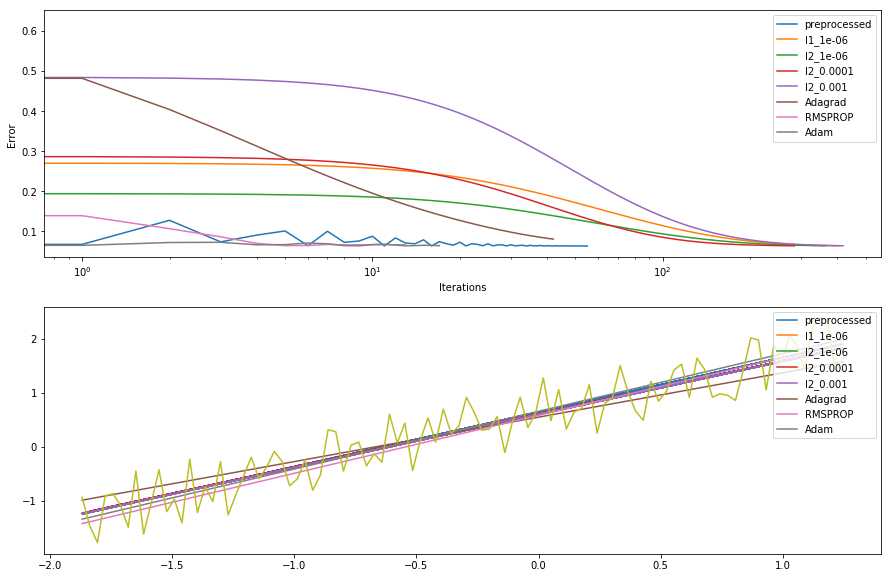

In [165]:
plt.clf()

fig = plt.figure(figsize=(15, 10))
error = plt.subplot(211)
linear_reg = plt.subplot(212)

x=generate_data(100)
#vanilla_gradient_descent(x,error,linear_reg,lamb=1e-5,stop_error=1e-5)
#gradient_descent(x,error,linear_reg,lamb=1e-4,stop_error=1e-5,batch_size=10,momentum=0.9)
gradient_descent_with_preprocessing(x,error,linear_reg,lamb=1e0,stop_error=1e-5,batch_size=100,momentum=0.9)
gradient_descent_with_l1_l2_norm(x,error,linear_reg,lamb=1e-3,stop_error=1e-5,batch_size=100,momentum=0.9,norm='l1',norm_coef=1e-6)
gradient_descent_with_l1_l2_norm(x,error,linear_reg,lamb=1e-3,stop_error=1e-5,batch_size=100,momentum=0.9,norm='l2',norm_coef=1e-6)
gradient_descent_with_l1_l2_norm(x,error,linear_reg,lamb=1e-3,stop_error=1e-5,batch_size=100,momentum=0.9,norm='l2',norm_coef=1e-4)
gradient_descent_with_l1_l2_norm(x,error,linear_reg,lamb=1e-3,stop_error=1e-5,batch_size=100,momentum=0.9,norm='l2',norm_coef=1e-3)
adagrad_gradient_descent(x,error,linear_reg,lamb=1e-1,stop_error=1e-3)
rmsprop_gradient_descent(x,error,linear_reg,lamb=1e-1,stop_error=1e-5)
adam_gradient_descent(x,error,linear_reg,lamb=1e-1,stop_error=1e-5)

error.set_xscale('log')
error.legend(loc='upper right')
error.set_xlabel('Iterations')
error.set_ylabel('Error')

linear_reg.plot(x[:,0],x[:,1])
linear_reg.legend(loc='upper right')
plt.show()